<a href="https://colab.research.google.com/github/diperezbgit/IA-FUNDAMENTALS/blob/main/TAREA_2/TAREA_2_HC_SA_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Vehicle Routing Problem (VRP) para Optimización de Rutas en Conexiones Eléctricas
### Se tiene una cuadrilla encargada de atender un conjunto de conexiones eléctricas distribuidas en diferentes distritos. El objetivo es optimizar el tiempo total de atención mediante la determinación del orden óptimo en que la cuadrilla debe visitar cada punto de conexión.




# Carga y visualización de imagen GIS de asignación ordenes de trabajo


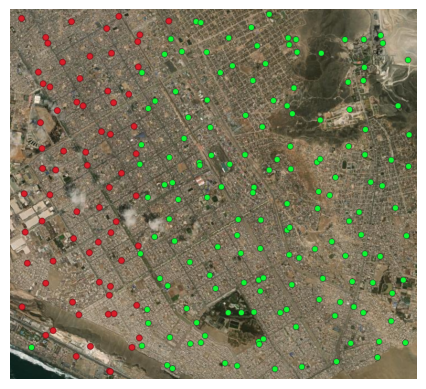

In [431]:
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO

url = 'https://raw.githubusercontent.com/diperezbgit/IA-FUNDAMENTALS/main/TAREA_2/cnx_gis.png'

response = requests.get(url)
img = Image.open(BytesIO(response.content))

plt.imshow(img)
plt.axis('off')  # Quita los ejes
plt.show()


# Importamos el archivo de ubicación de ordenes de **trabajo**



In [432]:
import pandas as pd
import numpy as np
#  obtenemos al archivo que contiene la informacion sobre las conexiones y ditancias entre ellas
path = r"https://raw.githubusercontent.com/diperezbgit/IA-FUNDAMENTALS/refs/heads/main/TAREA_2/cnx_cuadri02.csv"
df_long = pd.read_csv(path)
# par las pruebas usamos solo 70 puntos
df_reduced = df_long.iloc[:70, :70]
df_reduced


,id,y,x
0,0,8.651913e+06,286690.715164
1,1,8.651592e+06,287093.287133
2,2,8.651016e+06,286976.587931
3,3,8.651502e+06,287134.107559
4,4,8.650819e+06,287052.401729
...,...,...,...
65,65,8.646584e+06,288652.465776
66,66,8.646433e+06,288531.950857
67,67,8.646025e+06,288170.717954
68,68,8.651641e+06,288669.414069


# Funcion plot

In [434]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

def plot_tsp(nodes, route):
    """
    Plot the TSP nodes and route.

    Parameters:
    - nodes: List of tuples containing the coordinates of each node.
    - route: List of node indices representing the TSP route.
    """
    x = [node[0] for node in nodes]
    y = [node[1] for node in nodes]

    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, color='blue', zorder=2)  # Plot nodes


    for i in range(len(route) - 1):
        node1 = route[i]
        node2 = route[i + 1]
        plt.plot([nodes[node1][0], nodes[node2][0]], [nodes[node1][1], nodes[node2][1]], color='red', zorder=1)  # Plot route

    # Connect the last node to the first node to form a loop
    node1 = route[-1]
    node2 = route[0]
    plt.plot([nodes[node1][0], nodes[node2][0]], [nodes[node1][1], nodes[node2][1]], color='red', zorder=1)  # Plot route

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('TSP Nodes and Route')
    plt.grid(True)
    plt.show()

def plot_tsp_2(nodes, route, ax):
    """
    Plot the TSP nodes and route on the given axis.

    Parameters:
    - nodes: List of tuples containing the coordinates of each node.
    - route: List of node indices representing the TSP route.
    - ax: matplotlib axis to plot on.
    """
    x = [node[0] for node in nodes]
    y = [node[1] for node in nodes]

    ax.scatter(x, y, color='blue', zorder=2)  # Plot nodes

    for i in range(len(route) - 1):
        node1 = route[i]
        node2 = route[i + 1]
        ax.plot([nodes[node1][0], nodes[node2][0]], [nodes[node1][1], nodes[node2][1]], color='red', zorder=1)

    # Connect last node to first to form loop
    node1 = route[-1]
    node2 = route[0]
    ax.plot([nodes[node1][0], nodes[node2][0]], [nodes[node1][1], nodes[node2][1]], color='red', zorder=1)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('TSP Nodes and Route')
    ax.grid(True)

# Graficar ruta TSP estilo plot_routes
def plot_tsp_style(nodes, route, title, ax):
    """
    Plot the TSP nodes and route on the given axis, similar to plot_routes style.

    Parameters:
    - nodes: List of tuples containing the coordinates of each node.
    - route: List of node indices representing the TSP route.
    - title: Title of the plot.
    - ax: matplotlib axis to plot on.
    """
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.grid(True)

    # Coordenadas de los nodos
    x, y = zip(*nodes)
    ax.scatter(x, y, c='black', s=50, zorder=2)

    # Destacar el nodo inicial (depósito)
    ax.scatter(*nodes[0], c='yellow', s=100, edgecolors='black', label='Depósito', zorder=3)

    # Trazar la ruta
    full_route = route + [route[0]]  # cerrar el ciclo
    xs, ys = zip(*[nodes[i] for i in full_route])
    ax.plot(xs, ys, marker='o', color='blue', label='Ruta TSP', zorder=1)

    ax.legend()


# Hill Climbing

In [435]:
def fitness(sol,TSP):
  distance = 0
  for i in range( len(sol) - 1 ):
    distance = distance + TSP[ sol[i]  ][ sol[i+1]  ]
  return distance

def get_neighbors(sol):
  neighbors = []
  for i in range(len(sol) - 1):
    for j in range( i + 1, len(sol) ):
      new_sol = sol.copy()
      new_sol[i], new_sol[j] = new_sol[j], new_sol[i]
      neighbors.append(new_sol)
  return neighbors

def hill_climbing(num_cnx,positions,TSP):
  # step 1: Solucion inicial
  current_solution = np.array(range(num_cnx))
  np.random.shuffle(current_solution)
  sol_init = current_solution
  #plot_tsp(positions, current_solution)

  while True:
    #print("Iteration...")
    # step: generar vecinos
    neighbors = get_neighbors(current_solution)
    best_neighbor = min(neighbors, key=lambda current_solution: fitness(current_solution, TSP))

    #print("current_solution", current_solution)
    #print("fitness current_solution", fitness(current_solution,TSP))
    #print("fitness best_neighbor", fitness(best_neighbor,TSP))

    if fitness(best_neighbor,TSP) < fitness(current_solution,TSP):
      current_solution = best_neighbor
    else:
      return current_solution, fitness(current_solution,TSP), sol_init,fitness(sol_init,TSP)

# Simulated Annealing

In [436]:
def fitness(sol,TSP):
  distance = 0
  for i in range( len(sol) - 1 ):
    distance = distance + TSP[ sol[i]  ][ sol[i+1]  ]
  return distance

def random_neighbor(sol):
  i, j = np.random.choice(len(sol), 2, replace=False) # two random indices
  new_sol = sol.copy()
  new_sol[i], new_sol[j] = new_sol[j], new_sol[i]
  return new_sol

def accept(delta, T):
  if delta < 0:
    return True
  else: # damos la opcion de aceotar soluciones malas.
    r = np.random.rand() # random value between [0, 1]
    if r < np.exp(-delta/T):
      return True
    else:
      return False

def simulated_annealing(T_max, T_min, cooling_rate,positions,TSP):
  T = T_max
  initial_solution= np.array(list(range(len(TSP))))
  np.random.shuffle(initial_solution)

  x = initial_solution.copy()
  E = fitness(x,TSP)
  e_list=[]
  sol_init=x

  #print("temperatura:", T)
  #print("x", x)
  #print("E", E, "\n")

  while (T > T_min) :

    #e_list.append(E) # activar esto si se quiere plotear la energia, retornar valor
    x_new = random_neighbor(x)
    E_new = fitness(x_new,TSP)
    delta = E_new - E

    if accept(delta, T):
      x = x_new
      E = E_new

    T = T*cooling_rate
  return x,fitness(x,TSP),sol_init,fitness(sol_init,TSP)

# Ejecución de algoritmos

In [451]:
import time
# Crear datos
random.seed(42)

# Extraer coordenadas como array
N = len(df_reduced) # cantidad de conexiones
positions = df_reduced[['x', 'y']].values
TSP= squareform(pdist(positions, 'euclidean'))



In [452]:
inicio_hc = time.time()
sol_hc,fit_hc,sol_init_hc,fit_init_hc= hill_climbing(N,positions,TSP)
fin_hc = time.time()

#plot_tsp(positions, sol_hc)
print("\n 'good' solution:", sol_hc)
print("\n fitness:",fit_hc)
print("Tiempo de ejecución:",fin_hc-inicio_hc)


 'good' solution: [59 61 63 43 28 26 25 23 21 20 56 58 57 37 34 35 33 53 51 52 54 60 45 29
 46 67 66 65 62 64 44 41 42 40 55 50 48 69 68 16  2  4 17 32 31 49 30 47
 15  0  1  3  9 13 14 27 12  7  6  5 19 18 36 38 39 22 24  8 10 11]

 fitness: 42227.849005369135
Tiempo de ejecución: 8.058352708816528


In [453]:
T_max = 1000
T_min = 0.000001
#T_min = 0.1
cooling_rate = 0.9999

inicio_sa = time.time()
sol_sa, fit_sa,sol_init_sa,fit_init_sa = simulated_annealing(T_max, T_min, cooling_rate,positions,TSP)
fin_sa = time.time()

#plot_tsp(positions, sol_sa)
print("\n 'good' solution:", sol_sa)
print("\n fitness:",fit_sa)
print("Tiempo de ejecución:",fin_sa-inicio_sa)


 'good' solution: [55 34 35 18 17  2  4 19  5  6 20 21  7 11 13 14 27 26 12 25 38 36 37 39
 22 23  9 10  8 24 40 42 41 63 62 65 66 67 46 29 45 28 44 64 43 61 59 60
 57 58 56 54 52 50 49 48 68 69 47 30 31 15  0  1  3 16 32 33 53 51]

 fitness: 31921.144974929477
Tiempo de ejecución: 23.288676261901855


# Resultados

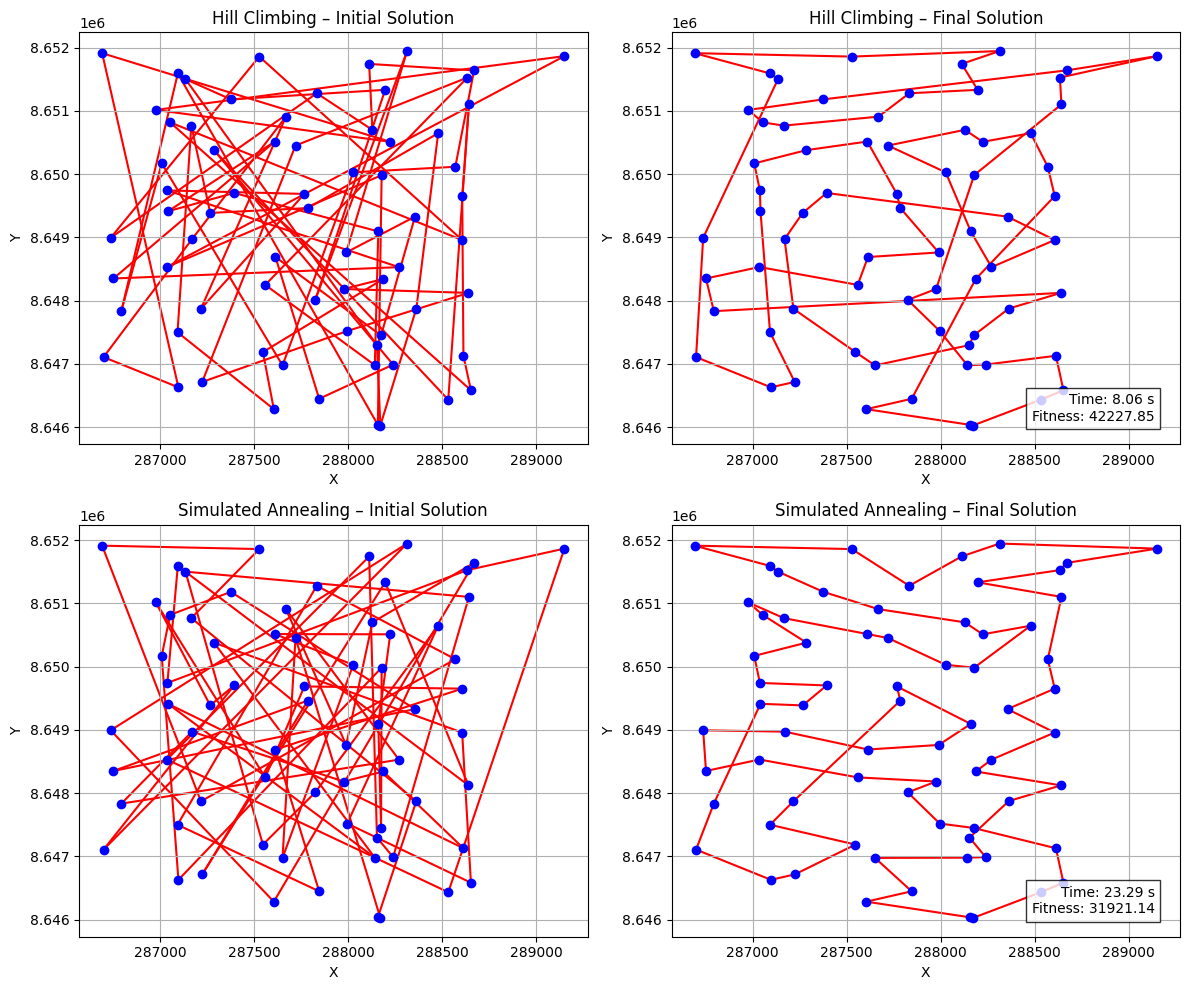

In [462]:

# graficamos
nodes = positions

route1 = sol_init_hc
dist1 = fit_init_hc
route2 = sol_hc
dist2 = fit_hc

route3 = sol_init_sa
dist3 = fit_init_sa
route4 = sol_sa
dist4 = fit_sa

## Subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

plot_tsp_2(nodes, route1, axs[0][0])
axs[0][0].set_title('Hill Climbing – Initial Solution')

plot_tsp_2(nodes, route2, axs[0][1])
axs[0][1].set_title('Hill Climbing – Final Solution')
axs[0][1].text(0.95, 0.05, f'Time: {fin_hc - inicio_hc:.2f} s\nFitness: {fit_hc:.2f}',
               transform=axs[0][1].transAxes,
               fontsize=10, verticalalignment='bottom', horizontalalignment='right',
               bbox=dict(facecolor='white', alpha=0.8))

plot_tsp_2(nodes, route3, axs[1][0])
axs[1][0].set_title('Simulated Annealing – Initial Solution')

plot_tsp_2(nodes, route4, axs[1][1])
axs[1][1].set_title('Simulated Annealing – Final Solution')
axs[1][1].text(0.95, 0.05, f'Time: {fin_sa - inicio_sa:.2f} s\nFitness: {fit_sa:.2f}',
               transform=axs[1][1].transAxes,
               fontsize=10, verticalalignment='bottom', horizontalalignment='right',
               bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()


In [454]:
route1 = sol_init_hc
dist1 = fit_init_hc
route2 = sol_hc
dist2 = fit_hc

route3 = sol_init_sa
dist3 = fit_init_sa
route4 = sol_sa
dist4 = fit_sa

In [455]:
route1

array([41, 59, 40, 60, 26, 29, 12, 17, 21, 38, 51, 61, 67, 43,  3, 16, 49,
       42, 47, 39, 56, 63, 22, 45, 64, 19, 66, 50, 54, 62, 65,  4, 58, 15,
        9, 31, 33, 30, 68, 52, 34, 28,  5, 11,  1, 46, 55,  8, 69,  2, 53,
        0, 14, 13, 23, 32, 25, 36,  6, 57, 10, 18,  7, 20, 37, 44, 24, 48,
       35, 27])

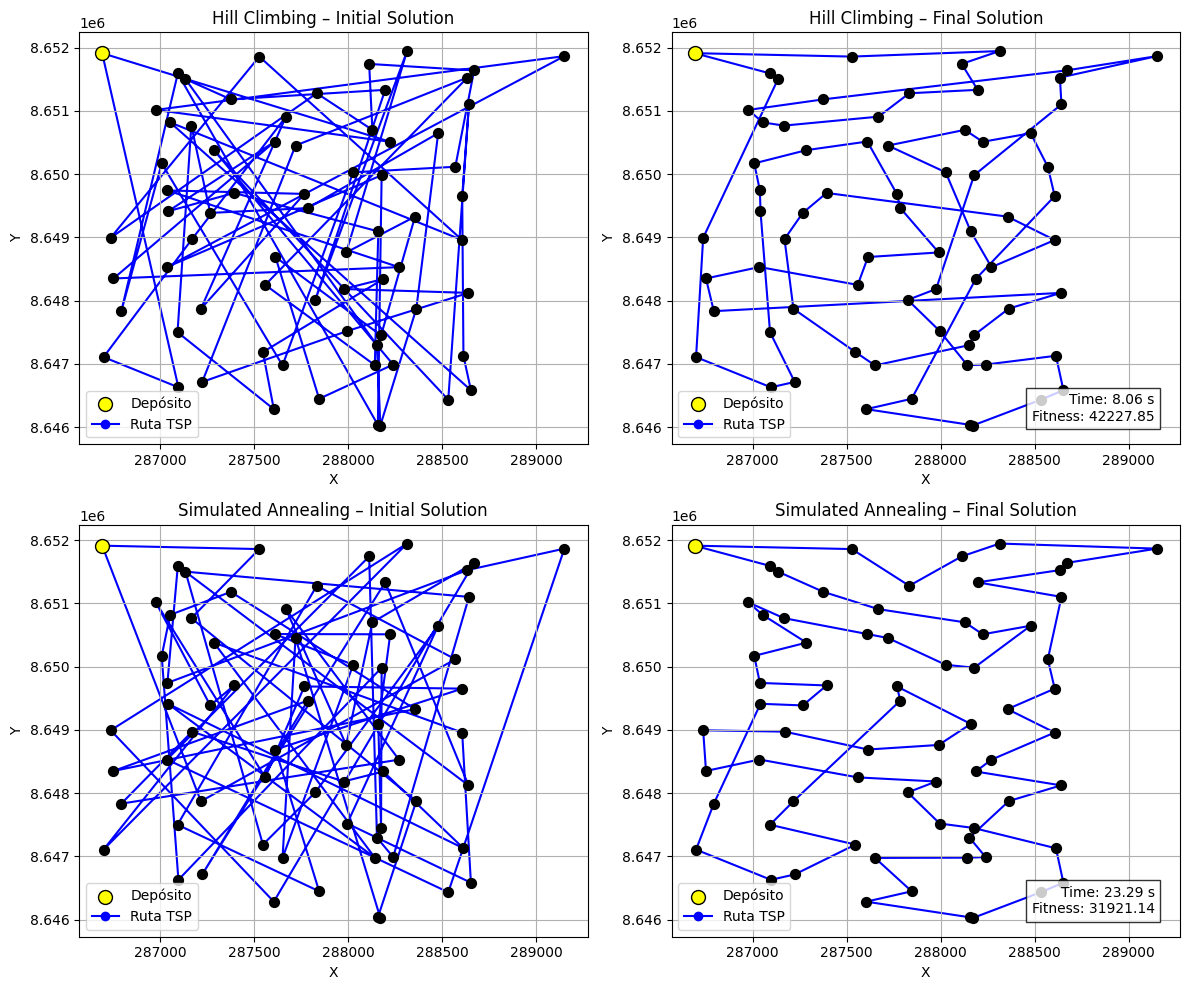

In [470]:
route1 = sol_init_hc
dist1 = fit_init_hc
route2 = sol_hc
dist2 = fit_hc

route3 = sol_init_sa
dist3 = fit_init_sa
route4 = sol_sa
dist4 = fit_sa

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

plot_tsp_style_2(nodes, route1, 'Hill Climbing – Initial Solution', axs[0][0])
plot_tsp_style_2(nodes, route2, 'Hill Climbing – Final Solution', axs[0][1], time=fin_hc - inicio_hc, fitness=fit_hc)
plot_tsp_style_2(nodes, route3, 'Simulated Annealing – Initial Solution', axs[1][0])
plot_tsp_style_2(nodes, route4, 'Simulated Annealing – Final Solution', axs[1][1], time=fin_sa - inicio_sa, fitness=fit_sa)

plt.tight_layout()
plt.show()



In [469]:
def plot_tsp_style_2(nodes, route, title, ax, time=None, fitness=None):
    """
    Grafica los nodos y la ruta TSP en el eje ax con estilo similar a plot_routes.

    Parámetros:
    - nodes: lista de tuplas (x, y) de los nodos.
    - route: lista o array con índices de nodos en la ruta.
    - title: título del gráfico.
    - ax: objeto matplotlib axis para graficar.
    - time: (opcional) tiempo transcurrido para mostrar en texto.
    - fitness: (opcional) valor fitness para mostrar en texto.
    """
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.grid(True)

    x, y = zip(*nodes)
    ax.scatter(x, y, c='black', s=50, zorder=2)
    ax.scatter(*nodes[0], c='yellow', s=100, edgecolors='black', label='Depósito', zorder=3)

    route_list = list(route)
    full_route = route_list + [route_list[0]]  # cerrar ciclo

    xs, ys = zip(*[nodes[i] for i in full_route])
    ax.plot(xs, ys, marker='o', color='blue', label='Ruta TSP', zorder=1)

    ax.legend()

    # Mostrar texto de tiempo y fitness si se provee
    if time is not None or fitness is not None:
        texto = ""
        if time is not None:
            texto += f"Time: {time:.2f} s\n"
        if fitness is not None:
            texto += f"Fitness: {fitness:.2f}"
        ax.text(0.95, 0.05, texto.strip(),
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment='bottom',
                horizontalalignment='right',
                bbox=dict(facecolor='white', alpha=0.8))



In [471]:
import matplotlib.pyplot as plt
import random
import math
import copy
import time

# Funciones auxiliares
def euclidean(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

def total_distance(routes, locations):
    distance = 0
    for route in routes:
        prev = 0
        for node in route:
            distance += euclidean(locations[prev], locations[node])
            prev = node
        distance += euclidean(locations[prev], locations[0])
    return distance

def initial_solution(num_vehicles, num_customers):
    customers = list(range(1, num_customers + 1))
    random.shuffle(customers)
    avg = len(customers) // num_vehicles
    return [customers[i*avg:(i+1)*avg] for i in range(num_vehicles-1)] + [customers[(num_vehicles-1)*avg:]]

# Algoritmo Hill Climbing
def hill_climbing(locations, num_vehicles, iterations=1000):
    current = initial_solution(num_vehicles, len(locations)-1)
    current_cost = total_distance(current, locations)

    for _ in range(iterations):
        neighbor = copy.deepcopy(current)
        r1, r2 = random.sample(range(len(neighbor)), 2)
        if neighbor[r1] and neighbor[r2]:
            i1 = random.randint(0, len(neighbor[r1]) - 1)
            i2 = random.randint(0, len(neighbor[r2]) - 1)
            neighbor[r1][i1], neighbor[r2][i2] = neighbor[r2][i2], neighbor[r1][i1]

            neighbor_cost = total_distance(neighbor, locations)
            if neighbor_cost < current_cost:
                current, current_cost = neighbor, neighbor_cost

    return current, current_cost

# Algoritmo Simulated Annealing

def simulated_annealing(locations, num_vehicles, iterations=1000, T_start=100, alpha=0.995):
    current = initial_solution(num_vehicles, len(locations)-1)
    current_cost = total_distance(current, locations)
    T = T_start

    for _ in range(iterations):
        neighbor = copy.deepcopy(current)
        r1, r2 = random.sample(range(len(neighbor)), 2)
        if neighbor[r1] and neighbor[r2]:
            i1 = random.randint(0, len(neighbor[r1]) - 1)
            i2 = random.randint(0, len(neighbor[r2]) - 1)
            neighbor[r1][i1], neighbor[r2][i2] = neighbor[r2][i2], neighbor[r1][i1]

            neighbor_cost = total_distance(neighbor, locations)
            delta = neighbor_cost - current_cost

            if delta < 0 or random.random() < math.exp(-delta / T):
                current, current_cost = neighbor, neighbor_cost

        T *= alpha

    return current, current_cost

# Graficar rutas
def plot_routes(locations, routes, title, ax):
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    ax.set_title(title)
    ax.scatter(*zip(*locations), c='black', s=50)
    ax.scatter(*locations[0], c='yellow', s=100, edgecolors='black', label='Depósito')

    for i, route in enumerate(routes):
        path = [0] + route + [0]
        xs, ys = zip(*[locations[i] for i in path])
        ax.plot(xs, ys, marker='o', color=colors[i % len(colors)], label=f'Vehículo {i+1}')

    ax.legend()




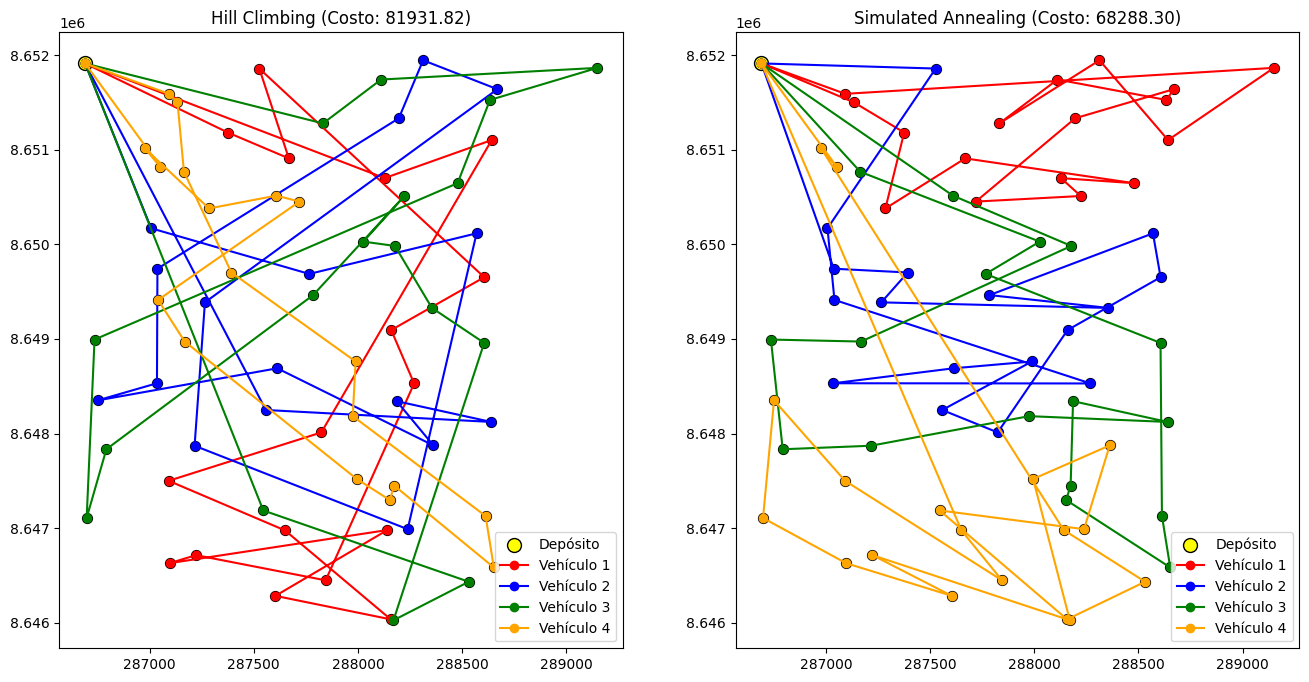

Hill Climbing Tiempo: 0.2675 segundos
Simulated Annealing Tiempo: 0.2493 segundos


In [472]:
# Crear datos
random.seed(42)

num_vehicles = 4
# o si quieres asegurarte que el primer punto sea (0,0) y luego los demás de positions:
locations = [(0, 0)] + positions


# Ejecutar
hc_solution, hc_cost = hill_climbing(locations, num_vehicles)
sa_solution, sa_cost = simulated_annealing(locations, num_vehicles)

# Graficar comparativo
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
plot_routes(locations, hc_solution, f"Hill Climbing (Costo: {hc_cost:.2f})", ax1)
plot_routes(locations, sa_solution, f"Simulated Annealing (Costo: {sa_cost:.2f})", ax2)
plt.show()


# Tiempo ejecución Hill Climbing
start = time.time()
hc_solution, hc_cost = hill_climbing(locations, num_vehicles)
end = time.time()
print(f"Hill Climbing Tiempo: {end - start:.4f} segundos")

# Tiempo ejecución Simulated Annealing
start = time.time()
sa_solution, sa_cost = simulated_annealing(locations, num_vehicles)
end = time.time()
print(f"Simulated Annealing Tiempo: {end - start:.4f} segundos")